# STEP 1: Imports and Get Data

In [1]:
from model_components.data_reader import FinancialTimeSeriesDataset
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 256      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 5

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 256
  d_ff                      : 1024
  d_freq                    : 3    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 2
  num_heads                 : 2
  dropout                   : 0.0

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : True   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' MSE
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [3]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
# CREATE DATASETS
train_dataset = FinancialTimeSeriesDataset(
    tickers=['^SPX'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=30,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='zscore',
    split='train',
    val_ratio=0.25,
    fit_scaler=True
)
scaler = train_dataset.scaler

val_dataset = FinancialTimeSeriesDataset(
    tickers=['^SPX'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=30,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='zscore',
    split='val',
    val_ratio=0.25,
    scaler=scaler
)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
Processing ^SPX (train): 100%|███████████████████████████████████████████████████████████████████████| 926/926 [00:00<00:00, 36014.63it/s]
[*********************100%***********************]  1 of 1 completed


tensor([[[-1.0748e+00, -1.0701e+00, -1.0773e+00, -1.0760e+00, -1.2834e+00,
           0.0000e+00],
         [-1.0803e+00, -1.0923e+00, -1.1135e+00, -1.1230e+00, -1.9937e-01,
           1.0000e+00],
         [-1.1207e+00, -1.1224e+00, -1.1449e+00, -1.1455e+00,  4.5776e-01,
           2.0000e+00],
         ...,
         [-1.0627e+00, -1.0687e+00, -1.0623e+00, -1.0630e+00, -4.0045e-01,
           2.7000e+01],
         [-1.0609e+00, -1.0500e+00, -1.0472e+00, -1.0381e+00, -2.1008e-01,
           2.8000e+01],
         [-1.0374e+00, -1.0394e+00, -1.0261e+00, -1.0274e+00, -4.6946e-01,
           2.9000e+01]],

        [[-1.1207e+00, -1.1224e+00, -1.1449e+00, -1.1455e+00,  4.5776e-01,
           2.0000e+00],
         [-1.1415e+00, -1.1232e+00, -1.1284e+00, -1.1164e+00, -1.9305e-01,
           3.0000e+00],
         [-1.1101e+00, -1.0803e+00, -1.0968e+00, -1.0710e+00, -6.5271e-02,
           4.0000e+00],
         ...,
         [-1.0374e+00, -1.0394e+00, -1.0261e+00, -1.0274e+00, -4.6946e-01,
    

Processing ^SPX (val): 100%|█████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 60666.05it/s]

tensor([[[ 1.0853e+00,  1.1000e+00,  1.0555e+00,  1.0846e+00,  8.3550e-01,
           1.8860e+03],
         [ 1.0791e+00,  1.1134e+00,  1.0725e+00,  1.1346e+00,  4.7009e-02,
           1.8870e+03],
         [ 1.0936e+00,  1.1164e+00,  1.0598e+00,  1.1422e+00,  1.0706e+00,
           1.8880e+03],
         ...,
         [ 1.5195e+00,  1.4955e+00,  1.5261e+00,  1.5063e+00, -8.6069e-02,
           1.9130e+03],
         [ 1.5794e+00,  1.5871e+00,  1.6082e+00,  1.6161e+00,  5.4316e-01,
           1.9140e+03],
         [ 1.6374e+00,  1.6453e+00,  1.6386e+00,  1.6124e+00,  6.2685e-01,
           1.9150e+03]],

        [[ 1.0936e+00,  1.1164e+00,  1.0598e+00,  1.1422e+00,  1.0706e+00,
           1.8880e+03],
         [ 1.1428e+00,  1.1645e+00,  1.1446e+00,  1.1593e+00,  4.1562e-01,
           1.8890e+03],
         [ 1.1764e+00,  1.2138e+00,  1.2070e+00,  1.2313e+00,  5.7766e-02,
           1.8900e+03],
         ...,
         [ 1.6374e+00,  1.6453e+00,  1.6386e+00,  1.6124e+00,  6.2685e-01,
    

In [5]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

# STEP 2: Set Up Model

In [6]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets[0].shape))
    print(targets[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets.shape)
    break

outputs = model(inputs)  # or model(inputs, something_else) if needed
print(outputs.shape)

model_stats = summary(model, input_data=inputs.to("cpu"), device="cpu")
print(model_stats)

6 1
First input sample (shape: torch.Size([30, 6])):
tensor([[-1.0748e+00, -1.0701e+00, -1.0773e+00, -1.0760e+00, -1.2834e+00,
          0.0000e+00],
        [-1.0803e+00, -1.0923e+00, -1.1135e+00, -1.1230e+00, -1.9937e-01,
          1.0000e+00],
        [-1.1207e+00, -1.1224e+00, -1.1449e+00, -1.1455e+00,  4.5776e-01,
          2.0000e+00],
        [-1.1415e+00, -1.1232e+00, -1.1284e+00, -1.1164e+00, -1.9305e-01,
          3.0000e+00],
        [-1.1101e+00, -1.0803e+00, -1.0968e+00, -1.0710e+00, -6.5271e-02,
          4.0000e+00],
        [-1.0691e+00, -1.0799e+00, -1.0870e+00, -1.0927e+00, -6.3182e-01,
          5.0000e+00],
        [-1.0907e+00, -1.0987e+00, -1.1069e+00, -1.1134e+00, -5.4003e-01,
          6.0000e+00],
        [-1.1089e+00, -1.0892e+00, -1.1249e+00, -1.1200e+00,  1.0701e-01,
          7.0000e+00],
        [-1.1254e+00, -1.1371e+00, -1.1499e+00, -1.1347e+00,  3.7680e-01,
          8.0000e+00],
        [-1.1312e+00, -1.1334e+00, -1.1461e+00, -1.1579e+00,  2.7544e-01,


# STEP 3: Setup WandB and Trainer

In [7]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gandotra/.netrc
wandb: Currently logged in as: nayeshag (nayeshag-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [8]:
# wandb.finish()

In [9]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin2",
    config_file="config.yaml",
    device=device
)
print("done with init!")

False
done with init!


here!

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False

📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (60 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (20 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


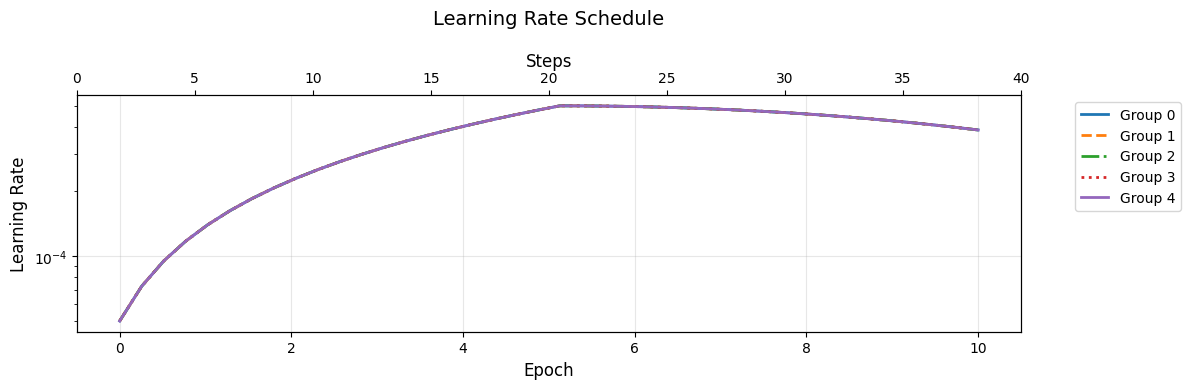

In [10]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=config['training']['epochs'], 
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

# Initialize WandB
if trainer.use_wandb:
    wandb.init(
        project=trainer.config['training'].get('wandb_project', 'time-series-forecasting'),
        config=trainer.config,
        name=trainer.run_name,
        settings=wandb.Settings(
        start_method="thread",             # don't spawn multiprocessing process
        _disable_stats=True,               # avoid launching resource monitor thread
        _disable_hardware_metrics=True     # same — these often cause hangs in Jupyter
        )
    )


# Step 4: TRAIN!!   

In [11]:
print("here!")
trainer.train(train_loader, val_loader, epochs=100)

Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s, accuracy=0.50%, loss=492.8697, mae=1.2667]

train predictions are tensor([[0.4790],
        [0.4927],
        [0.5444],
        [0.6099],
        [0.6675]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.6958],
        [0.6958],
        [0.6958],
        [0.6958],
        [0.6958]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.3748],
        [0.3748],
        [0.3745],
        [0.3748],
        [0.3745]], device='cuda:0', dtype=torch.float16,
       grad_fn=

torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.1077],
        [0.1077],
        [0.1077],
        [0.1077],
        [0.1077]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[0.1138],
        [0.1138],
        [0.1138],
        [0.1138],
        [0.1138]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 0 Metrics:
  TRAIN      | train_loss: 2.1290 | train_mae: 1.2667 | train_accuracy: 0.4968
  VAL        | val_loss: 5.2206 | val_mae: 2.1148 | val_accuracy: 0.0000


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.90it/s, accuracy=0.32%, loss=266.5136, mae=1.0606]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.6313],
        [-0.6143],
        [-0.5630],
        [-0.4961],
        [-0.4460]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.0893],
        [-0.0891],
        [-0.0891],
        [-0.0889],
        [-0.0891]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1698],
        [-0.16

torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[-0.1181],
        [-0.1181],
        [-0.1181],
        [-0.1181],
        [-0.1181]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[-0.0994],
        [-0.0994],
        [-0.0994],
        [-0.0994],
        [-0.0994]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 1 Metrics:
  TRAIN      | train_loss: 1.1512 | train_mae: 1.0606 | train_accuracy: 0.3240
  VAL        | val_loss: 6.1865 | val_mae: 2.3337 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.52it/s, accuracy=1.05%, loss=45.7277, mae=0.9080]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.5977],
        [-1.5811],
        [-1.5244],
        [-1.4580],
        [-1.4150]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.2632],
        [-0.2627],
        [-0.2629],
        [-0.2627],
        [-0.2627]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1082],
        [-0.10

Training:  75%|█████████████████████████████████████▌            | 3/4 [00:00<00:00, 25.88it/s, accuracy=1.02%, loss=173.1478, mae=0.9155]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.0110],
        [0.0112],
        [0.0111],
        [0.0114],
        [0.0112]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.01it/s, accuracy=1.02%, loss=173.1478, mae=0.9155]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.2079],
        [0.2079],
        [0.2079],
        [0.2079],
        [0.2079]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[0.2396],
        [0.2396],
        [0.2396],
        [0.2396],
        [0.2396]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 2 Metrics:
  TRAIN      | train_loss: 0.7479 | train_mae: 0.9155 | train_accuracy: 1.0151
  VAL        | val_loss: 4.7335 | val_mae: 2.0004 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.29it/s, accuracy=0.20%, loss=95.3470, mae=0.8625]

train predictions are tensor([[-2.2051],
        [-2.1934],
        [-2.1426],
        [-2.0781],
        [-2.0410]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.0423],
        [0.0425],
        [0.0426],
        [0.0426],
        [0.0425]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.88it/s, accuracy=0.86%, loss=126.9026, mae=0.8448]

train predictions are tensor([[0.3337],
        [0.3337],
        [0.3335],
        [0.3337],
        [0.3337]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.5005],
        [0.5010],
        [0.5010],
        [0.5010],
        [0.5005]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.7017],
        [0.7017],
        [0.7017],
        [0.7017],
        [0.7017]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[0.7460],
        [0.7460],
        [0.7460],
        [0.7460],
        [0.7460]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 3 Metrics:
  TRAIN      | train_loss: 0.5482 | train_mae: 0.8448 | train_accuracy: 0.8639
  VAL        | val_loss: 2.9723 | val_mae: 1.4994 | val_accuracy: 0.0000


Training:   0%|                                                          | 0/4 [00:00<?, ?it/s, accuracy=2.42%, loss=208.4006, mae=0.8444]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-2.3926],
        [-2.3828],
        [-2.3398],
        [-2.2832],
        [-2.2520]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.3811],
        [0.3811],
        [0.3813],
        [0.3816],
        [0.3816]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.98it/s, accuracy=0.99%, loss=171.3562, mae=0.8352]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.6836],
        [0.6836],
        [0.6836],
        [0.6836],
        [0.6836]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.7837],
        [0.7832],
        [0.7832],
        [0.7832],
        [0.7832]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.8967],
        [0.8967],
        [0.8967],
        [0.8967],
        [0.8967]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[0.9578],
        [0.9578],
        [0.9578],
        [0.9578],
        [0.9578]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 4 Metrics:
  TRAIN      | train_loss: 0.7402 | train_mae: 0.8352 | train_accuracy: 0.9935
  VAL        | val_loss: 2.3906 | val_mae: 1.2960 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▌                                     | 1/4 [00:00<00:00, 10.28it/s, accuracy=0.35%, loss=217.5681, mae=0.8401]

train predictions are tensor([[-2.3418],
        [-2.3359],
        [-2.3027],
        [-2.2578],
        [-2.2344]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.3337],
        [0.3337],
        [0.3340],
        [0.3342],
        [0.3340]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.58it/s, accuracy=0.63%, loss=179.0012, mae=0.8309]

train predictions are tensor([[0.6167],
        [0.6162],
        [0.6162],
        [0.6162],
        [0.6167]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.6602],
        [0.6602],
        [0.6602],
        [0.6602],
        [0.6602]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.7245],
        [0.7245],
        [0.7245],
        [0.7245],
        [0.7245]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[0.8049],
        [0.8049],
        [0.8049],
        [0.8049],
        [0.8049]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 5 Metrics:
  TRAIN      | train_loss: 0.7732 | train_mae: 0.8309 | train_accuracy: 0.6263
  VAL        | val_loss: 2.8237 | val_mae: 1.4564 | val_accuracy: 0.0000


Training:  25%|████████████▌                                     | 1/4 [00:00<00:00, 10.29it/s, accuracy=1.13%, loss=122.1112, mae=0.8154]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-2.0391],
        [-2.0391],
        [-2.0156],
        [-1.9824],
        [-1.9697]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[8.1301e-05],
        [2.6846e-04],
        [3.9864e-04],
        [2.7895e-04],
        [6.7854e-04]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.3687],


Training:  75%|█████████████████████████████████████▌            | 3/4 [00:00<00:00, 25.46it/s, accuracy=1.30%, loss=140.8610, mae=0.8085]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.4690],
        [0.4690],
        [0.4690],
        [0.4690],
        [0.4690]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.81it/s, accuracy=1.30%, loss=140.8610, mae=0.8085]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.6048],
        [0.6048],
        [0.6048],
        [0.6048],
        [0.6048]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[0.7013],
        [0.7013],
        [0.7013],
        [0.7013],
        [0.7013]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 6 Metrics:
  TRAIN      | train_loss: 0.6085 | train_mae: 0.8085 | train_accuracy: 1.2959
  VAL        | val_loss: 3.1504 | val_mae: 1.5675 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.38it/s, accuracy=0.12%, loss=82.5398, mae=0.7880]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.2559],
        [-1.2588],
        [-1.2480],
        [-1.2305],
        [-1.2236]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1279],
        [-0.1278],
        [-0.1277],
        [-0.1277],
        [-0.1277]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.3838],
        [0.3838

Training:  75%|█████████████████████████████████████▌            | 3/4 [00:00<00:00, 25.65it/s, accuracy=0.95%, loss=110.0863, mae=0.7813]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.5796],
        [0.5796],
        [0.5796],
        [0.5796],
        [0.5796]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.86it/s, accuracy=0.95%, loss=110.0863, mae=0.7813]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.7863],
        [0.7863],
        [0.7863],
        [0.7863],
        [0.7863]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[0.8940],
        [0.8940],
        [0.8940],
        [0.8940],
        [0.8940]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 7 Metrics:
  TRAIN      | train_loss: 0.4755 | train_mae: 0.7813 | train_accuracy: 0.9503
  VAL        | val_loss: 2.5924 | val_mae: 1.3806 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.35it/s, accuracy=1.37%, loss=97.3209, mae=0.7680]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1311],
        [-0.1383],
        [-0.1393],
        [-0.1326],
        [-0.1304]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.0228],
        [0.0227],
        [0.0226],
        [0.0228],
        [0.0229]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.5625],
        [0.5625],
  

Training:  75%|█████████████████████████████████████▌            | 3/4 [00:00<00:00, 25.55it/s, accuracy=1.17%, loss=109.2743, mae=0.7630]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.7402],
        [0.7402],
        [0.7402],
        [0.7402],
        [0.7402]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.86it/s, accuracy=1.17%, loss=109.2743, mae=0.7630]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.9088],
        [0.9088],
        [0.9088],
        [0.9088],
        [0.9088]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.0314],
        [1.0314],
        [1.0314],
        [1.0314],
        [1.0314]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 8 Metrics:
  TRAIN      | train_loss: 0.4720 | train_mae: 0.7630 | train_accuracy: 1.1663
  VAL        | val_loss: 2.2410 | val_mae: 1.2519 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.38it/s, accuracy=1.45%, loss=99.5857, mae=0.7517]

train predictions are tensor([[0.4263],
        [0.4199],
        [0.4175],
        [0.4202],
        [0.4209]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.0326],
        [-0.0328],
        [-0.0324],
        [-0.0325],
        [-0.0324]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.47it/s, accuracy=1.17%, loss=114.5210, mae=0.7484]

train predictions are tensor([[0.5059],
        [0.5063],
        [0.5063],
        [0.5059],
        [0.5059]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.6572],
        [0.6572],
        [0.6572],
        [0.6572],
        [0.6572]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.8150],
        [0.8150],
        [0.8150],
        [0.8150],
        [0.8150]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[0.9625],
        [0.9625],
        [0.9625],
        [0.9625],
        [0.9625]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 9 Metrics:
  TRAIN      | train_loss: 0.4947 | train_mae: 0.7484 | train_accuracy: 1.1663
  VAL        | val_loss: 2.4349 | val_mae: 1.3312 | val_accuracy: 0.0000


Training:  50%|█████████████████████████▌                         | 2/4 [00:00<00:00, 19.90it/s, accuracy=1.45%, loss=65.2832, mae=0.7332]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.0887],
        [0.0853],
        [0.0851],
        [0.0882],
        [0.0893]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.2507],
        [-0.2510],
        [-0.2507],
        [-0.2510],
        [-0.2505]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.4387],
        [0.4387],
  

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 19.90it/s, accuracy=1.12%, loss=92.3897, mae=0.7296]

train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.6821],
        [0.6816],
        [0.6816],
        [0.6821],
        [0.6821]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.34it/s, accuracy=1.12%, loss=92.3897, mae=0.7296]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.9098],
        [0.9098],
        [0.9098],
        [0.9098],
        [0.9098]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.0799],
        [1.0799],
        [1.0799],
        [1.0799],
        [1.0799]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 10 Metrics:
  TRAIN      | train_loss: 0.3991 | train_mae: 0.7296 | train_accuracy: 1.1231
  VAL        | val_loss: 2.1495 | val_mae: 1.2262 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:   0%|                                                           | 0/4 [00:00<?, ?it/s, accuracy=5.86%, loss=40.4507, mae=0.7199]

train predictions are tensor([[-0.2480],
        [-0.2505],
        [-0.2468],
        [-0.2423],
        [-0.2378]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1997],
        [-0.1996],
        [-0.1998],
        [-0.1993],
        [-0.1993]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s, accuracy=2.20%, loss=93.4755, mae=0.7157]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.5850],
        [0.5850],
        [0.5850],
        [0.5850],
        [0.5850]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.8408],
        [0.8408],
        [0.8408],
        [0.8408],
        [0.8408]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.0332],
        [1.0332],
        [1.0332],
        [1.0332],
        [1.0332]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.2240],
        [1.2240],
        [1.2240],
        [1.2240],
        [1.2240]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 11 Metrics:
  TRAIN      | train_loss: 0.4038 | train_mae: 0.7157 | train_accuracy: 2.2030
  VAL        | val_loss: 1.8273 | val_mae: 1.0984 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  50%|█████████████████████████▌                         | 2/4 [00:00<00:00, 19.75it/s, accuracy=3.79%, loss=67.3718, mae=0.7040]

train predictions are tensor([[-0.4368],
        [-0.4380],
        [-0.4338],
        [-0.4290],
        [-0.4199]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.2274],
        [-0.2273],
        [-0.2274],
        [-0.2275],
        [-0.2273]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.42it/s, accuracy=2.42%, loss=91.2971, mae=0.7022]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.5127],
        [0.5127],
        [0.5132],
        [0.5132],
        [0.5132]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.7446],
        [0.7446],
        [0.7446],
        [0.7451],
        [0.7446]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[0.9360],
        [0.9360],
        [0.9360],
        [0.9360],
        [0.9360]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.1595],
        [1.1595],
        [1.1595],
        [1.1595],
        [1.1595]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 12 Metrics:
  TRAIN      | train_loss: 0.3944 | train_mae: 0.7022 | train_accuracy: 2.4190
  VAL        | val_loss: 1.9899 | val_mae: 1.1735 | val_accuracy: 0.0000


Training:  50%|█████████████████████████▌                         | 2/4 [00:00<00:00, 19.99it/s, accuracy=1.95%, loss=44.4448, mae=0.6884]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8628],
        [-0.8638],
        [-0.8608],
        [-0.8521],
        [-0.8398]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.4138],
        [-0.4136],
        [-0.4138],
        [-0.4136],
        [-0.4136]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.4580],
        [0.4578

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 19.99it/s, accuracy=1.32%, loss=73.2441, mae=0.6859]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.7993],
        [0.7993],
        [0.7993],
        [0.7993],
        [0.7993]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.76it/s, accuracy=1.32%, loss=73.2441, mae=0.6859]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.0553],
        [1.0553],
        [1.0553],
        [1.0553],
        [1.0553]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.3076],
        [1.3076],
        [1.3076],
        [1.3076],
        [1.3076]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 13 Metrics:
  TRAIN      | train_loss: 0.3164 | train_mae: 0.6859 | train_accuracy: 1.3175
  VAL        | val_loss: 1.6781 | val_mae: 1.0466 | val_accuracy: 0.0000


Training:   0%|                                                           | 0/4 [00:00<?, ?it/s, accuracy=22.34%, loss=6.0197, mae=0.6751]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8057],
        [-0.8086],
        [-0.8071],
        [-0.7974],
        [-0.7812]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.40it/s, accuracy=7.26%, loss=72.0085, mae=0.6708]

train predictions are tensor([[-0.4099],
        [-0.4102],
        [-0.4104],
        [-0.4102],
        [-0.4102]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.5039],
        [0.5039],
        [0.5034],
        [0.5039],
        [0.5039]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.8491],
        [0.8486],
        [0.8486],
        [0.8491],
        [0.8491]], device='cuda:0', dtype=torch.float16,
       gra

torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.0665],
        [1.0665],
        [1.0665],
        [1.0665],
        [1.0665]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.3663],
        [1.3663],
        [1.3663],
        [1.3663],
        [1.3663]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 14 Metrics:
  TRAIN      | train_loss: 0.3111 | train_mae: 0.6708 | train_accuracy: 7.2570
  VAL        | val_loss: 1.5815 | val_mae: 1.0130 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  50%|█████████████████████████▌                         | 2/4 [00:00<00:00, 19.96it/s, accuracy=0.20%, loss=41.4979, mae=0.6595]

train predictions are tensor([[-1.2783],
        [-1.2803],
        [-1.2773],
        [-1.2666],
        [-1.2500]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.5991],
        [-0.5991],
        [-0.5991],
        [-0.5991],
        [-0.5991]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.41it/s, accuracy=1.12%, loss=67.6999, mae=0.6579]

train predictions are tensor([[0.5186],
        [0.5186],
        [0.5181],
        [0.5181],
        [0.5181]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.9326],
        [0.9326],
        [0.9326],
        [0.9326],
        [0.9326]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.1420],
        [1.1420],
        [1.1420],
        [1.1420],
        [1.1420]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.4831],
        [1.4831],
        [1.4831],
        [1.4831],
        [1.4831]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 15 Metrics:
  TRAIN      | train_loss: 0.2924 | train_mae: 0.6579 | train_accuracy: 1.1231
  VAL        | val_loss: 1.3756 | val_mae: 0.9268 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  50%|█████████████████████████▌                         | 2/4 [00:00<00:00, 19.92it/s, accuracy=0.82%, loss=27.9969, mae=0.6451]

train predictions are tensor([[-0.7578],
        [-0.7598],
        [-0.7578],
        [-0.7476],
        [-0.7310]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.6797],
        [-0.6797],
        [-0.6797],
        [-0.6797],
        [-0.6797]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.38it/s, accuracy=1.40%, loss=56.6429, mae=0.6425]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.2849],
        [0.2847],
        [0.2847],
        [0.2844],
        [0.2847]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.8120],
        [0.8120],
        [0.8120],
        [0.8120],
        [0.8120]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.1632],
        [1.1632],
        [1.1632],
        [1.1632],
        [1.1632]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.5750],
        [1.5750],
        [1.5750],
        [1.5750],
        [1.5750]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 16 Metrics:
  TRAIN      | train_loss: 0.2447 | train_mae: 0.6425 | train_accuracy: 1.4039
  VAL        | val_loss: 1.2404 | val_mae: 0.8756 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▌                                     | 1/4 [00:00<00:00, 10.22it/s, accuracy=0.78%, loss=102.6496, mae=0.6406]

train predictions are tensor([[-1.9639],
        [-1.9658],
        [-1.9639],
        [-1.9561],
        [-1.9414]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.6860],
        [-0.6860],
        [-0.6860],
        [-0.6865],
        [-0.6865]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.62it/s, accuracy=0.65%, loss=113.8754, mae=0.6421]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.7905],
        [0.7905],
        [0.7900],
        [0.7905],
        [0.7905]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.2285],
        [1.2285],
        [1.2285],
        [1.2285],
        [1.2285]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.1778],
        [1.1778],
        [1.1778],
        [1.1778],
        [1.1778]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.5995],
        [1.5995],
        [1.5995],
        [1.5995],
        [1.5995]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 17 Metrics:
  TRAIN      | train_loss: 0.4919 | train_mae: 0.6421 | train_accuracy: 0.6479
  VAL        | val_loss: 1.1997 | val_mae: 0.8592 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.5996],
        [-0.6011],
        [-0.6016],
        [-0.5942],
        [-0.5811]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.84it/s, accuracy=0.58%, loss=116.9318, mae=0.6379]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.6050],
        [-0.6050],
        [-0.6055],
        [-0.6055],
        [-0.6055]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.3687],
        [-0.3684],
        [-0.3684],
        [-0.3684],
        [-0.3684]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.3582],
        [0.3582

torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.1991],
        [1.1991],
        [1.1991],
        [1.1991],
        [1.1991]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.7043],
        [1.7043],
        [1.7043],
        [1.7043],
        [1.7043]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 18 Metrics:
  TRAIN      | train_loss: 0.5051 | train_mae: 0.6379 | train_accuracy: 0.5832
  VAL        | val_loss: 1.0555 | val_mae: 0.8017 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▌                                     | 1/4 [00:00<00:00, 10.39it/s, accuracy=0.00%, loss=107.3695, mae=0.6365]

train predictions are tensor([[-1.7979],
        [-1.7988],
        [-1.7979],
        [-1.7930],
        [-1.7832]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.4165],
        [-0.4165],
        [-0.4165],
        [-0.4167],
        [-0.4172]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.88it/s, accuracy=3.50%, loss=179.5713, mae=0.6428]

train predictions are tensor([[1.2197],
        [1.2197],
        [1.2197],
        [1.2197],
        [1.2197]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.5752],
        [1.5752],
        [1.5752],
        [1.5752],
        [1.5752]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.0448],
        [1.0448],
        [1.0448],
        [1.0448],
        [1.0448]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.5755],
        [1.5755],
        [1.5755],
        [1.5755],
        [1.5755]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 19 Metrics:
  TRAIN      | train_loss: 0.7757 | train_mae: 0.6428 | train_accuracy: 3.4989
  VAL        | val_loss: 1.2874 | val_mae: 0.9241 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.38it/s, accuracy=0.43%, loss=45.1599, mae=0.6363]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.5205],
        [-1.5205],
        [-1.5205],
        [-1.5166],
        [-1.5098]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.1992],
        [-1.1992],
        [-1.1992],
        [-1.1992],
        [-1.1992]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.3267],
        [-0.32

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.58it/s, accuracy=0.28%, loss=91.5771, mae=0.6374]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.4941],
        [0.4941],
        [0.4939],
        [0.4941],
        [0.4941]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.89it/s, accuracy=0.28%, loss=91.5771, mae=0.6374]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.1381],
        [1.1381],
        [1.1381],
        [1.1381],
        [1.1381]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.5453],
        [1.5453],
        [1.5453],
        [1.5453],
        [1.5453]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 20 Metrics:
  TRAIN      | train_loss: 0.3956 | train_mae: 0.6374 | train_accuracy: 0.2808
  VAL        | val_loss: 1.2977 | val_mae: 0.9062 | val_accuracy: 0.0000


Training:  25%|████████████▌                                     | 1/4 [00:00<00:00, 10.46it/s, accuracy=0.00%, loss=196.4101, mae=0.6434]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.3774],
        [-0.3794],
        [-0.3801],
        [-0.3779],
        [-0.3713]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.1770],
        [0.1770],
        [0.1770],
        [0.1769],
        [0.1768]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.6655],
        [0.6650],
  

Training:  75%|█████████████████████████████████████▌            | 3/4 [00:00<00:00, 26.02it/s, accuracy=0.39%, loss=143.6058, mae=0.6425]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.1338],
        [1.1338],
        [1.1338],
        [1.1338],
        [1.1338]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.15it/s, accuracy=0.39%, loss=143.6058, mae=0.6425]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.1161],
        [1.1161],
        [1.1161],
        [1.1161],
        [1.1161]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.5998],
        [1.5998],
        [1.5998],
        [1.5998],
        [1.5998]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 21 Metrics:
  TRAIN      | train_loss: 0.6203 | train_mae: 0.6425 | train_accuracy: 0.3888
  VAL        | val_loss: 1.2354 | val_mae: 0.8903 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.43it/s, accuracy=3.32%, loss=13.6087, mae=0.6316]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.4463],
        [-1.4453],
        [-1.4443],
        [-1.4424],
        [-1.4385]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.9448],
        [-0.9448],
        [-0.9448],
        [-0.9448],
        [-0.9448]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.1665],
        [0.1664

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.88it/s, accuracy=2.76%, loss=34.2044, mae=0.6276]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.9717],
        [0.9722],
        [0.9717],
        [0.9722],
        [0.9717]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.94it/s, accuracy=2.76%, loss=34.2044, mae=0.6276]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.1573],
        [1.1573],
        [1.1573],
        [1.1573],
        [1.1573]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.6935],
        [1.6935],
        [1.6935],
        [1.6935],
        [1.6935]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 22 Metrics:
  TRAIN      | train_loss: 0.1478 | train_mae: 0.6276 | train_accuracy: 2.7646
  VAL        | val_loss: 1.1002 | val_mae: 0.8327 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.33it/s, accuracy=1.64%, loss=87.7493, mae=0.6249]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.8320],
        [-1.8311],
        [-1.8301],
        [-1.8291],
        [-1.8262]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.9458],
        [-0.9453],
        [-0.9453],
        [-0.9453],
        [-0.9453]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.5840],
        [0.5840

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.72it/s, accuracy=1.81%, loss=83.4765, mae=0.6233]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3750],
        [1.3750],
        [1.3750],
        [1.3750],
        [1.3750]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.04it/s, accuracy=1.81%, loss=83.4765, mae=0.6233]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.2909],
        [1.2910],
        [1.2910],
        [1.2910],
        [1.2910]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.8379],
        [1.8379],
        [1.8379],
        [1.8379],
        [1.8379]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 23 Metrics:
  TRAIN      | train_loss: 0.3606 | train_mae: 0.6233 | train_accuracy: 1.8143
  VAL        | val_loss: 0.8871 | val_mae: 0.7258 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.24it/s, accuracy=7.23%, loss=14.9551, mae=0.6138]

train predictions are tensor([[-1.1982],
        [-1.1982],
        [-1.1982],
        [-1.1973],
        [-1.1953]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7876],
        [-0.7876],
        [-0.7881],
        [-0.7881],
        [-0.7881]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.86it/s, accuracy=5.25%, loss=36.0012, mae=0.6107]

train predictions are tensor([[0.2195],
        [0.2195],
        [0.2196],
        [0.2196],
        [0.2195]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.9692],
        [0.9688],
        [0.9692],
        [0.9692],
        [0.9692]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.0475],
        [1.0475],
        [1.0475],
        [1.0475],
        [1.0475]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.6027],
        [1.6027],
        [1.6027],
        [1.6027],
        [1.6027]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 24 Metrics:
  TRAIN      | train_loss: 0.1555 | train_mae: 0.6107 | train_accuracy: 5.2484
  VAL        | val_loss: 1.2567 | val_mae: 0.9179 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.22it/s, accuracy=4.53%, loss=10.7208, mae=0.6011]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7080],
        [-0.7085],
        [-0.7090],
        [-0.7085],
        [-0.7070]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.6738],
        [-0.6743],
        [-0.6743],
        [-0.6743],
        [-0.6743]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.1550],
        [0.1550

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.54it/s, accuracy=3.78%, loss=26.9486, mae=0.5972]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.0547],
        [1.0547],
        [1.0547],
        [1.0547],
        [1.0547]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.99it/s, accuracy=3.78%, loss=26.9486, mae=0.5972]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.2036],
        [1.2036],
        [1.2036],
        [1.2036],
        [1.2036]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.8145],
        [1.8145],
        [1.8145],
        [1.8145],
        [1.8145]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 25 Metrics:
  TRAIN      | train_loss: 0.1164 | train_mae: 0.5972 | train_accuracy: 3.7797
  VAL        | val_loss: 0.9294 | val_mae: 0.7578 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.32it/s, accuracy=3.44%, loss=13.6295, mae=0.5888]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7178],
        [-0.7183],
        [-0.7188],
        [-0.7178],
        [-0.7158]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.6895],
        [-0.6895],
        [-0.6899],
        [-0.6895],
        [-0.6899]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.2769],
        [0.2769

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.42it/s, accuracy=3.35%, loss=27.5021, mae=0.5854]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.2793],
        [1.2803],
        [1.2793],
        [1.2793],
        [1.2793]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.94it/s, accuracy=3.35%, loss=27.5021, mae=0.5854]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.2643],
        [1.2643],
        [1.2643],
        [1.2643],
        [1.2643]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[1.9673],
        [1.9673],
        [1.9673],
        [1.9673],
        [1.9673]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 26 Metrics:
  TRAIN      | train_loss: 0.1188 | train_mae: 0.5854 | train_accuracy: 3.3477
  VAL        | val_loss: 0.7443 | val_mae: 0.6694 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|█████████████                                       | 1/4 [00:00<00:00, 10.24it/s, accuracy=6.45%, loss=8.3042, mae=0.5767]

train predictions are tensor([[-1.0586],
        [-1.0576],
        [-1.0576],
        [-1.0576],
        [-1.0547]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.9854],
        [-0.9854],
        [-0.9854],
        [-0.9854],
        [-0.9858]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.92it/s, accuracy=5.12%, loss=18.1259, mae=0.5724]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.0932],
        [0.0931],
        [0.0929],
        [0.0931],
        [0.0931]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.2637],
        [1.2637],
        [1.2637],
        [1.2637],
        [1.2637]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.2677],
        [1.2677],
        [1.2677],
        [1.2677],
        [1.2677]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.0470],
        [2.0470],
        [2.0470],
        [2.0470],
        [2.0470]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 27 Metrics:
  TRAIN      | train_loss: 0.0783 | train_mae: 0.5724 | train_accuracy: 5.1188
  VAL        | val_loss: 0.6603 | val_mae: 0.6305 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.43it/s, accuracy=2.07%, loss=12.6007, mae=0.5652]

train predictions are tensor([[-1.1748],
        [-1.1748],
        [-1.1748],
        [-1.1738],
        [-1.1719]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.9883],
        [-0.9883],
        [-0.9883],
        [-0.9883],
        [-0.9883]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.99it/s, accuracy=3.52%, loss=19.3628, mae=0.5610]

train predictions are tensor([[0.1038],
        [0.1038],
        [0.1039],
        [0.1038],
        [0.1040]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3809],
        [1.3809],
        [1.3809],
        [1.3809],
        [1.3809]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3148],
        [1.3148],
        [1.3148],
        [1.3148],
        [1.3148]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.1461],
        [2.1461],
        [2.1461],
        [2.1461],
        [2.1461]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 28 Metrics:
  TRAIN      | train_loss: 0.0836 | train_mae: 0.5610 | train_accuracy: 3.5205
  VAL        | val_loss: 0.5596 | val_mae: 0.5751 | val_accuracy: 0.0000


Training:   0%|                                                           | 0/4 [00:00<?, ?it/s, accuracy=38.75%, loss=1.5581, mae=0.5562]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0068],
        [-1.0059],
        [-1.0059],
        [-1.0049],
        [-1.0029]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.11it/s, accuracy=14.92%, loss=11.3707, mae=0.5474]

train predictions are tensor([[-0.8032],
        [-0.8032],
        [-0.8032],
        [-0.8032],
        [-0.8037]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.0268],
        [0.0268],
        [0.0267],
        [0.0268],
        [0.0268]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.2432],
        [1.2432],
        [1.2432],
        [1.2432],
        [1.2432]], device='cuda:0', dtype=torch.float16,
       gra

torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.2424],
        [1.2424],
        [1.2424],
        [1.2424],
        [1.2424]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.1279],
        [2.1279],
        [2.1279],
        [2.1279],
        [2.1279]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 29 Metrics:
  TRAIN      | train_loss: 0.0491 | train_mae: 0.5474 | train_accuracy: 14.9244
  VAL        | val_loss: 0.5860 | val_mae: 0.5984 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.41it/s, accuracy=11.41%, loss=3.6025, mae=0.5391]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.9282],
        [-0.9277],
        [-0.9277],
        [-0.9272],
        [-0.9253]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7388],
        [-0.7383],
        [-0.7383],
        [-0.7383],
        [-0.7383]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.0150],
        [0.0148

Training:  75%|███████████████████████████████████████             | 3/4 [00:00<00:00, 25.35it/s, accuracy=9.65%, loss=9.2400, mae=0.5342]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3184],
        [1.3184],
        [1.3184],
        [1.3184],
        [1.3184]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.57it/s, accuracy=9.65%, loss=9.2400, mae=0.5342]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.2930],
        [1.2930],
        [1.2930],
        [1.2930],
        [1.2930]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.2515],
        [2.2515],
        [2.2515],
        [2.2515],
        [2.2515]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 30 Metrics:
  TRAIN      | train_loss: 0.0399 | train_mae: 0.5342 | train_accuracy: 9.6544
  VAL        | val_loss: 0.4673 | val_mae: 0.5288 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.32it/s, accuracy=23.98%, loss=2.8048, mae=0.5263]

train predictions are tensor([[-1.0264],
        [-1.0254],
        [-1.0254],
        [-1.0244],
        [-1.0234]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8257],
        [-0.8257],
        [-0.8257],
        [-0.8257],
        [-0.8257]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.91it/s, accuracy=18.06%, loss=7.4868, mae=0.5214]

train predictions are tensor([[-0.0393],
        [-0.0394],
        [-0.0394],
        [-0.0394],
        [-0.0395]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.4121],
        [1.4121],
        [1.4121],
        [1.4121],
        [1.4121]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3037],
        [1.3037],
        [1.3037],
        [1.3037],
        [1.3037]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.3322],
        [2.3322],
        [2.3322],
        [2.3322],
        [2.3322]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 31 Metrics:
  TRAIN      | train_loss: 0.0323 | train_mae: 0.5214 | train_accuracy: 18.0562
  VAL        | val_loss: 0.4005 | val_mae: 0.4887 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|█████████████                                       | 1/4 [00:00<00:00, 10.32it/s, accuracy=5.78%, loss=5.0648, mae=0.5146]

train predictions are tensor([[-1.1221],
        [-1.1221],
        [-1.1211],
        [-1.1201],
        [-1.1182]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8892],
        [-0.8887],
        [-0.8887],
        [-0.8887],
        [-0.8892]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.72it/s, accuracy=8.42%, loss=6.8483, mae=0.5095]

train predictions are tensor([[-0.1041],
        [-0.1041],
        [-0.1044],
        [-0.1041],
        [-0.1042]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3857],
        [1.3857],
        [1.3857],
        [1.3857],
        [1.3857]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3093],
        [1.3093],
        [1.3093],
        [1.3093],
        [1.3093]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.3762],
        [2.3762],
        [2.3762],
        [2.3762],
        [2.3762]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 32 Metrics:
  TRAIN      | train_loss: 0.0296 | train_mae: 0.5095 | train_accuracy: 8.4233
  VAL        | val_loss: 0.3645 | val_mae: 0.4660 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0498],
        [-1.0498],
        [-1.0488],
        [-1.0488],
        [-1.0469]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.10it/s, accuracy=20.97%, loss=5.4594, mae=0.4975]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7695],
        [-0.7695],
        [-0.7695],
        [-0.7695],
        [-0.7695]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.0398],
        [-0.0398],
        [-0.0397],
        [-0.0398],
        [-0.0397]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3838],
        [1.3838

torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.2776],
        [1.2776],
        [1.2776],
        [1.2776],
        [1.2776]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.3741],
        [2.3741],
        [2.3741],
        [2.3741],
        [2.3741]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 33 Metrics:
  TRAIN      | train_loss: 0.0236 | train_mae: 0.4975 | train_accuracy: 20.9719
  VAL        | val_loss: 0.3641 | val_mae: 0.4688 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.30it/s, accuracy=24.61%, loss=2.3134, mae=0.4907]

train predictions are tensor([[-1.0381],
        [-1.0381],
        [-1.0381],
        [-1.0371],
        [-1.0352]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7646],
        [-0.7646],
        [-0.7646],
        [-0.7646],
        [-0.7646]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.81it/s, accuracy=18.73%, loss=4.7079, mae=0.4861]

train predictions are tensor([[-0.0970],
        [-0.0971],
        [-0.0970],
        [-0.0971],
        [-0.0970]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3301],
        [1.3301],
        [1.3301],
        [1.3301],
        [1.3301]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.2956],
        [1.2957],
        [1.2957],
        [1.2957],
        [1.2956]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4214],
        [2.4214],
        [2.4214],
        [2.4214],
        [2.4214]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 34 Metrics:
  TRAIN      | train_loss: 0.0203 | train_mae: 0.4861 | train_accuracy: 18.7257
  VAL        | val_loss: 0.3266 | val_mae: 0.4424 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])


Training:   0%|                                                           | 0/4 [00:00<?, ?it/s, accuracy=36.48%, loss=1.2561, mae=0.4827]

torch.Size([256, 30, 260])
train predictions are tensor([[-1.0889],
        [-1.0879],
        [-1.0879],
        [-1.0869],
        [-1.0859]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7671],
        [-0.7671],
        [-0.7671],
        [-0.7671],
        [-0.7676]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.53it/s, accuracy=20.67%, loss=4.8036, mae=0.4752]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.0614],
        [-0.0615],
        [-0.0614],
        [-0.0614],
        [-0.0613]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.4502],
        [1.4502],
        [1.4502],
        [1.4512],
        [1.4502]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3069],
        [1.3069],
        [1.3069],
        [1.3069],
        [1.3069]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4566],
        [2.4566],
        [2.4566],
        [2.4566],
        [2.4566]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 35 Metrics:
  TRAIN      | train_loss: 0.0207 | train_mae: 0.4752 | train_accuracy: 20.6695
  VAL        | val_loss: 0.3068 | val_mae: 0.4289 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.29it/s, accuracy=14.34%, loss=3.2807, mae=0.4694]

train predictions are tensor([[-1.1318],
        [-1.1318],
        [-1.1318],
        [-1.1309],
        [-1.1299]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8271],
        [-0.8276],
        [-0.8276],
        [-0.8276],
        [-0.8276]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.79it/s, accuracy=11.58%, loss=4.8011, mae=0.4653]

train predictions are tensor([[-0.1665],
        [-0.1665],
        [-0.1663],
        [-0.1661],
        [-0.1663]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.2930],
        [1.2930],
        [1.2930],
        [1.2930],
        [1.2930]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3602],
        [1.3602],
        [1.3602],
        [1.3602],
        [1.3602]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4955],
        [2.4955],
        [2.4955],
        [2.4955],
        [2.4955]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 36 Metrics:
  TRAIN      | train_loss: 0.0207 | train_mae: 0.4653 | train_accuracy: 11.5767
  VAL        | val_loss: 0.2858 | val_mae: 0.4118 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.18it/s, accuracy=24.02%, loss=2.0760, mae=0.4594]

train predictions are tensor([[-1.0732],
        [-1.0732],
        [-1.0732],
        [-1.0723],
        [-1.0703]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.6914],
        [-0.6914],
        [-0.6914],
        [-0.6914],
        [-0.6914]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.50it/s, accuracy=19.24%, loss=5.4264, mae=0.4558]

train predictions are tensor([[-0.0045],
        [-0.0044],
        [-0.0044],
        [-0.0044],
        [-0.0045]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.4775],
        [1.4775],
        [1.4775],
        [1.4775],
        [1.4775]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3419],
        [1.3419],
        [1.3419],
        [1.3419],
        [1.3419]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4858],
        [2.4858],
        [2.4858],
        [2.4858],
        [2.4858]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 37 Metrics:
  TRAIN      | train_loss: 0.0234 | train_mae: 0.4558 | train_accuracy: 19.2441
  VAL        | val_loss: 0.3032 | val_mae: 0.4292 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.44it/s, accuracy=17.38%, loss=3.2202, mae=0.4506]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.1084],
        [-1.1074],
        [-1.1074],
        [-1.1074],
        [-1.1055]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8193],
        [-0.8193],
        [-0.8193],
        [-0.8193],
        [-0.8193]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.2163],
        [-0.21

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.83it/s, accuracy=11.60%, loss=6.8713, mae=0.4476]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.1865],
        [1.1865],
        [1.1865],
        [1.1865],
        [1.1865]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.01it/s, accuracy=11.60%, loss=6.8713, mae=0.4476]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3976],
        [1.3976],
        [1.3977],
        [1.3977],
        [1.3977]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.5276],
        [2.5276],
        [2.5276],
        [2.5276],
        [2.5276]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 38 Metrics:
  TRAIN      | train_loss: 0.0297 | train_mae: 0.4476 | train_accuracy: 11.5983
  VAL        | val_loss: 0.2728 | val_mae: 0.4022 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.19it/s, accuracy=16.84%, loss=2.8427, mae=0.4425]

train predictions are tensor([[-1.0723],
        [-1.0723],
        [-1.0723],
        [-1.0723],
        [-1.0703]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.6519],
        [-0.6514],
        [-0.6519],
        [-0.6514],
        [-0.6519]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s, accuracy=10.95%, loss=10.4645, mae=0.4404]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.0696],
        [0.0695],
        [0.0697],
        [0.0697],
        [0.0696]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.6221],
        [1.6221],
        [1.6221],
        [1.6221],
        [1.6211]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3531],
        [1.3531],
        [1.3531],
        [1.3531],
        [1.3531]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4943],
        [2.4943],
        [2.4943],
        [2.4943],
        [2.4943]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 39 Metrics:
  TRAIN      | train_loss: 0.0452 | train_mae: 0.4404 | train_accuracy: 10.9503
  VAL        | val_loss: 0.2974 | val_mae: 0.4267 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.33it/s, accuracy=12.97%, loss=6.4047, mae=0.4362]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.1426],
        [-1.1416],
        [-1.1416],
        [-1.1416],
        [-1.1396]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8882],
        [-0.8882],
        [-0.8882],
        [-0.8882],
        [-0.8882]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.3228],
        [-0.32

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.56it/s, accuracy=7.34%, loss=18.1994, mae=0.4352]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.9722],
        [0.9722],
        [0.9722],
        [0.9727],
        [0.9727]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.94it/s, accuracy=7.34%, loss=18.1994, mae=0.4352]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3549],
        [1.3549],
        [1.3549],
        [1.3549],
        [1.3549]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4605],
        [2.4605],
        [2.4605],
        [2.4605],
        [2.4605]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 40 Metrics:
  TRAIN      | train_loss: 0.0786 | train_mae: 0.4352 | train_accuracy: 7.3434
  VAL        | val_loss: 0.3178 | val_mae: 0.4410 | val_accuracy: 0.0000


Training:  25%|█████████████                                       | 1/4 [00:00<00:00, 10.47it/s, accuracy=9.34%, loss=8.0183, mae=0.4314]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0283],
        [-1.0283],
        [-1.0283],
        [-1.0273],
        [-1.0264]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.5454],
        [-0.5454],
        [-0.5454],
        [-0.5449],
        [-0.5454]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.2202],
        [0.2202

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.86it/s, accuracy=5.16%, loss=23.7892, mae=0.4312]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.7832],
        [1.7832],
        [1.7832],
        [1.7832],
        [1.7832]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.05it/s, accuracy=5.16%, loss=23.7892, mae=0.4312]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4198],
        [1.4198],
        [1.4198],
        [1.4198],
        [1.4198]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.5267],
        [2.5267],
        [2.5267],
        [2.5267],
        [2.5267]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 41 Metrics:
  TRAIN      | train_loss: 0.1028 | train_mae: 0.4312 | train_accuracy: 5.1620
  VAL        | val_loss: 0.2636 | val_mae: 0.3935 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.26it/s, accuracy=17.15%, loss=5.9593, mae=0.4272]

train predictions are tensor([[-1.1191],
        [-1.1191],
        [-1.1191],
        [-1.1182],
        [-1.1172]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8896],
        [-0.8896],
        [-0.8901],
        [-0.8901],
        [-0.8901]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.61it/s, accuracy=9.61%, loss=28.6538, mae=0.4276]

train predictions are tensor([[-0.3779],
        [-0.3779],
        [-0.3779],
        [-0.3779],
        [-0.3779]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[0.7896],
        [0.7891],
        [0.7896],
        [0.7891],
        [0.7891]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.2034],
        [1.2034],
        [1.2034],
        [1.2034],
        [1.2034]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.2714],
        [2.2714],
        [2.2714],
        [2.2714],
        [2.2714]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 42 Metrics:
  TRAIN      | train_loss: 0.1238 | train_mae: 0.4276 | train_accuracy: 9.6112
  VAL        | val_loss: 0.4882 | val_mae: 0.5843 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.31it/s, accuracy=19.96%, loss=3.5073, mae=0.4233]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0840],
        [-1.0840],
        [-1.0840],
        [-1.0830],
        [-1.0820]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.6260],
        [-0.6260],
        [-0.6260],
        [-0.6260],
        [-0.6260]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.1870],
        [0.1870

Training:  75%|█████████████████████████████████████▌            | 3/4 [00:00<00:00, 25.63it/s, accuracy=11.04%, loss=19.4237, mae=0.4229]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.8096],
        [1.8096],
        [1.8096],
        [1.8096],
        [1.8096]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|██████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.67it/s, accuracy=11.04%, loss=19.4237, mae=0.4229]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.6163],
        [1.6163],
        [1.6163],
        [1.6163],
        [1.6163]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.6593],
        [2.6593],
        [2.6593],
        [2.6593],
        [2.6593]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 43 Metrics:
  TRAIN      | train_loss: 0.0839 | train_mae: 0.4229 | train_accuracy: 11.0367
  VAL        | val_loss: 0.1914 | val_mae: 0.3434 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0527],
        [-1.0518],
        [-1.0518],
        [-1.0518],
        [-1.0498]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s, accuracy=12.72%, loss=8.4982, mae=0.4166]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7363],
        [-0.7363],
        [-0.7363],
        [-0.7363],
        [-0.7363]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1771],
        [-0.1771],
        [-0.1769],
        [-0.1769],
        [-0.1770]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.0674],
        [1.0664

torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.1974],
        [1.1974],
        [1.1974],
        [1.1974],
        [1.1974]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.2180],
        [2.2180],
        [2.2180],
        [2.2180],
        [2.2180]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 44 Metrics:
  TRAIN      | train_loss: 0.0367 | train_mae: 0.4166 | train_accuracy: 12.7214
  VAL        | val_loss: 0.5235 | val_mae: 0.6054 | val_accuracy: 0.0000


Training:  25%|█████████████                                       | 1/4 [00:00<00:00, 10.28it/s, accuracy=5.27%, loss=4.4997, mae=0.4130]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.1670],
        [-1.1660],
        [-1.1670],
        [-1.1660],
        [-1.1650]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8521],
        [-0.8521],
        [-0.8521],
        [-0.8521],
        [-0.8521]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1213],
        [-0.12

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.38it/s, accuracy=11.66%, loss=4.4228, mae=0.4099]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.4326],
        [1.4326],
        [1.4326],
        [1.4326],
        [1.4326]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.77it/s, accuracy=11.66%, loss=4.4228, mae=0.4099]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.5333],
        [1.5333],
        [1.5333],
        [1.5333],
        [1.5333]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.5354],
        [2.5354],
        [2.5354],
        [2.5354],
        [2.5354]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 45 Metrics:
  TRAIN      | train_loss: 0.0191 | train_mae: 0.4099 | train_accuracy: 11.6631
  VAL        | val_loss: 0.2416 | val_mae: 0.3741 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.33it/s, accuracy=27.19%, loss=2.2341, mae=0.4058]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0518],
        [-1.0508],
        [-1.0518],
        [-1.0508],
        [-1.0498]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.6948],
        [-0.6948],
        [-0.6943],
        [-0.6948],
        [-0.6948]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[0.0130],
        [0.0131

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.61it/s, accuracy=19.74%, loss=6.3842, mae=0.4036]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.5059],
        [1.5068],
        [1.5068],
        [1.5059],
        [1.5059]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.99it/s, accuracy=19.74%, loss=6.3842, mae=0.4036]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4390],
        [1.4390],
        [1.4390],
        [1.4390],
        [1.4390]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4369],
        [2.4369],
        [2.4369],
        [2.4369],
        [2.4369]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 46 Metrics:
  TRAIN      | train_loss: 0.0276 | train_mae: 0.4036 | train_accuracy: 19.7408
  VAL        | val_loss: 0.3005 | val_mae: 0.4180 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.26it/s, accuracy=24.41%, loss=2.3021, mae=0.3998]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0479],
        [-1.0479],
        [-1.0479],
        [-1.0479],
        [-1.0459]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8145],
        [-0.8140],
        [-0.8145],
        [-0.8145],
        [-0.8145]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1931],
        [-0.19

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.46it/s, accuracy=15.72%, loss=5.2621, mae=0.3976]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.1992],
        [1.1992],
        [1.1992],
        [1.1992],
        [1.1992]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.82it/s, accuracy=15.72%, loss=5.2621, mae=0.3976]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3183],
        [1.3183],
        [1.3183],
        [1.3183],
        [1.3183]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.3097],
        [2.3097],
        [2.3097],
        [2.3097],
        [2.3097]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 47 Metrics:
  TRAIN      | train_loss: 0.0227 | train_mae: 0.3976 | train_accuracy: 15.7235
  VAL        | val_loss: 0.4047 | val_mae: 0.5055 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0303],
        [-1.0303],
        [-1.0303],
        [-1.0303],
        [-1.0293]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.27it/s, accuracy=24.84%, loss=1.7895, mae=0.3938]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7817],
        [-0.7812],
        [-0.7812],
        [-0.7812],
        [-0.7812]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.0872],
        [-0.0871],
        [-0.0871],
        [-0.0872],
        [-0.0870]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.89it/s, accuracy=22.74%, loss=3.2920, mae=0.3911]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.4482],
        [1.4482],
        [1.4482],
        [1.4482],
        [1.4482]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.5029],
        [1.5029],
        [1.5029],
        [1.5029],
        [1.5029]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4979],
        [2.4980],
        [2.4980],
        [2.4980],
        [2.4980]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 48 Metrics:
  TRAIN      | train_loss: 0.0142 | train_mae: 0.3911 | train_accuracy: 22.7430
  VAL        | val_loss: 0.2575 | val_mae: 0.3844 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.33it/s, accuracy=28.52%, loss=1.8707, mae=0.3874]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.9941],
        [-0.9941],
        [-0.9941],
        [-0.9941],
        [-0.9927]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7227],
        [-0.7227],
        [-0.7222],
        [-0.7222],
        [-0.7222]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.0601],
        [-0.05

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.70it/s, accuracy=24.45%, loss=3.7367, mae=0.3850]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.4277],
        [1.4277],
        [1.4277],
        [1.4277],
        [1.4277]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.78it/s, accuracy=24.45%, loss=3.7367, mae=0.3850]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4243],
        [1.4243],
        [1.4243],
        [1.4243],
        [1.4243]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4263],
        [2.4263],
        [2.4263],
        [2.4263],
        [2.4263]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 49 Metrics:
  TRAIN      | train_loss: 0.0161 | train_mae: 0.3850 | train_accuracy: 24.4492
  VAL        | val_loss: 0.3049 | val_mae: 0.4226 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.27it/s, accuracy=23.20%, loss=2.0531, mae=0.3816]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0498],
        [-1.0498],
        [-1.0498],
        [-1.0498],
        [-1.0488]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.8047],
        [-0.8047],
        [-0.8042],
        [-0.8047],
        [-0.8047]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1626],
        [-0.16

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.35it/s, accuracy=17.82%, loss=3.3685, mae=0.3792]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3018],
        [1.3018],
        [1.3018],
        [1.3018],
        [1.3018]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.80it/s, accuracy=17.82%, loss=3.3685, mae=0.3792]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3788],
        [1.3788],
        [1.3788],
        [1.3788],
        [1.3788]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.3853],
        [2.3853],
        [2.3853],
        [2.3853],
        [2.3853]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 50 Metrics:
  TRAIN      | train_loss: 0.0146 | train_mae: 0.3792 | train_accuracy: 17.8186
  VAL        | val_loss: 0.3378 | val_mae: 0.4512 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.29it/s, accuracy=20.12%, loss=1.7473, mae=0.3758]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0664],
        [-1.0654],
        [-1.0664],
        [-1.0664],
        [-1.0645]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7852],
        [-0.7847],
        [-0.7847],
        [-0.7847],
        [-0.7847]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1059],
        [-0.10

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.73it/s, accuracy=20.52%, loss=2.9199, mae=0.3734]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.4141],
        [1.4141],
        [1.4141],
        [1.4141],
        [1.4141]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.07it/s, accuracy=20.52%, loss=2.9199, mae=0.3734]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4677],
        [1.4677],
        [1.4677],
        [1.4677],
        [1.4677]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4790],
        [2.4790],
        [2.4790],
        [2.4790],
        [2.4790]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 51 Metrics:
  TRAIN      | train_loss: 0.0126 | train_mae: 0.3734 | train_accuracy: 20.5184
  VAL        | val_loss: 0.2691 | val_mae: 0.3932 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.27it/s, accuracy=33.91%, loss=1.4654, mae=0.3700]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0381],
        [-1.0391],
        [-1.0391],
        [-1.0391],
        [-1.0371]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7378],
        [-0.7378],
        [-0.7378],
        [-0.7378],
        [-0.7383]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.0778],
        [-0.07

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.45it/s, accuracy=28.44%, loss=2.9776, mae=0.3677]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.4102],
        [1.4102],
        [1.4102],
        [1.4102],
        [1.4102]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.85it/s, accuracy=28.44%, loss=2.9776, mae=0.3677]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4328],
        [1.4328],
        [1.4328],
        [1.4328],
        [1.4328]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4503],
        [2.4503],
        [2.4503],
        [2.4503],
        [2.4503]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 52 Metrics:
  TRAIN      | train_loss: 0.0129 | train_mae: 0.3677 | train_accuracy: 28.4449
  VAL        | val_loss: 0.2894 | val_mae: 0.4106 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.14it/s, accuracy=28.87%, loss=1.5335, mae=0.3645]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0518],
        [-1.0518],
        [-1.0518],
        [-1.0518],
        [-1.0498]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7700],
        [-0.7700],
        [-0.7695],
        [-0.7700],
        [-0.7700]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1283],
        [-0.12

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.10it/s, accuracy=22.83%, loss=2.7524, mae=0.3623]

train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3369],
        [1.3369],
        [1.3369],
        [1.3369],
        [1.3369]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.69it/s, accuracy=22.83%, loss=2.7524, mae=0.3623]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.3946],
        [1.3946],
        [1.3946],
        [1.3946],
        [1.3946]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4176],
        [2.4176],
        [2.4176],
        [2.4176],
        [2.4176]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 53 Metrics:
  TRAIN      | train_loss: 0.0119 | train_mae: 0.3623 | train_accuracy: 22.8294
  VAL        | val_loss: 0.3147 | val_mae: 0.4332 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.24it/s, accuracy=25.82%, loss=1.5475, mae=0.3593]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0635],
        [-1.0635],
        [-1.0645],
        [-1.0635],
        [-1.0625]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7729],
        [-0.7729],
        [-0.7729],
        [-0.7729],
        [-0.7729]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1167],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.31it/s, accuracy=22.72%, loss=2.6397, mae=0.3571]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3779],
        [1.3779],
        [1.3779],
        [1.3779],
        [1.3779]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.75it/s, accuracy=22.72%, loss=2.6397, mae=0.3571]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4370],
        [1.4370],
        [1.4370],
        [1.4370],
        [1.4370]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4645],
        [2.4645],
        [2.4645],
        [2.4645],
        [2.4645]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 54 Metrics:
  TRAIN      | train_loss: 0.0114 | train_mae: 0.3571 | train_accuracy: 22.7214
  VAL        | val_loss: 0.2801 | val_mae: 0.4035 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.12it/s, accuracy=29.45%, loss=1.3829, mae=0.3541]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0537],
        [-1.0537],
        [-1.0537],
        [-1.0527],
        [-1.0518]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7495],
        [-0.7495],
        [-0.7495],
        [-0.7495],
        [-0.7495]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.0950],
        [-0.09

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 24.94it/s, accuracy=25.62%, loss=2.6704, mae=0.3520]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.4043],
        [1.4043],
        [1.4043],
        [1.4043],
        [1.4043]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.48it/s, accuracy=25.62%, loss=2.6704, mae=0.3520]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4427],
        [1.4427],
        [1.4427],
        [1.4427],
        [1.4427]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4745],
        [2.4745],
        [2.4745],
        [2.4745],
        [2.4745]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 55 Metrics:
  TRAIN      | train_loss: 0.0115 | train_mae: 0.3520 | train_accuracy: 25.6156
  VAL        | val_loss: 0.2732 | val_mae: 0.3979 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.35it/s, accuracy=29.69%, loss=1.4099, mae=0.3490]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7573],
        [-0.7578],
        [-0.7573],
        [-0.7573],
        [-0.7578]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1140],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.87it/s, accuracy=24.54%, loss=2.5488, mae=0.3470]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3701],
        [1.3701],
        [1.3701],
        [1.3701],
        [1.3701]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.01it/s, accuracy=24.54%, loss=2.5488, mae=0.3470]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4154],
        [1.4154],
        [1.4154],
        [1.4154],
        [1.4154]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4511],
        [2.4511],
        [2.4511],
        [2.4511],
        [2.4511]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 56 Metrics:
  TRAIN      | train_loss: 0.0110 | train_mae: 0.3470 | train_accuracy: 24.5356
  VAL        | val_loss: 0.2900 | val_mae: 0.4131 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.24it/s, accuracy=27.58%, loss=1.4802, mae=0.3442]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0625],
        [-1.0625],
        [-1.0625],
        [-1.0625],
        [-1.0615]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7681],
        [-0.7681],
        [-0.7681],
        [-0.7681],
        [-0.7681]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1251],
        [-0.12

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.65it/s, accuracy=23.52%, loss=2.5410, mae=0.3423]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3643],
        [1.3643],
        [1.3643],
        [1.3643],
        [1.3643]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.03it/s, accuracy=23.52%, loss=2.5410, mae=0.3423]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4200],
        [1.4200],
        [1.4200],
        [1.4200],
        [1.4200]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4583],
        [2.4583],
        [2.4583],
        [2.4583],
        [2.4583]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 57 Metrics:
  TRAIN      | train_loss: 0.0110 | train_mae: 0.3423 | train_accuracy: 23.5205
  VAL        | val_loss: 0.2848 | val_mae: 0.4088 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.16it/s, accuracy=28.59%, loss=1.3987, mae=0.3396]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0586],
        [-1.0586],
        [-1.0586],
        [-1.0586],
        [-1.0576]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7588],
        [-0.7588],
        [-0.7588],
        [-0.7588],
        [-0.7588]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1131],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.27it/s, accuracy=24.84%, loss=2.5023, mae=0.3377]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3848],
        [1.3848],
        [1.3848],
        [1.3848],
        [1.3848]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.79it/s, accuracy=24.84%, loss=2.5023, mae=0.3377]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4355],
        [1.4355],
        [1.4355],
        [1.4355],
        [1.4355]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4761],
        [2.4761],
        [2.4761],
        [2.4761],
        [2.4761]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 58 Metrics:
  TRAIN      | train_loss: 0.0108 | train_mae: 0.3377 | train_accuracy: 24.8380
  VAL        | val_loss: 0.2721 | val_mae: 0.3978 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.14it/s, accuracy=30.59%, loss=1.3614, mae=0.3350]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0527],
        [-1.0527],
        [-1.0527],
        [-1.0527],
        [-1.0518]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7510],
        [-0.7505],
        [-0.7510],
        [-0.7510],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1088],
        [-0.10

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 24.99it/s, accuracy=26.00%, loss=2.4856, mae=0.3332]

train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3848],
        [1.3848],
        [1.3848],
        [1.3848],
        [1.3857]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.42it/s, accuracy=26.00%, loss=2.4856, mae=0.3332]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4309],
        [1.4309],
        [1.4309],
        [1.4309],
        [1.4309]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4738],
        [2.4738],
        [2.4738],
        [2.4738],
        [2.4738]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 59 Metrics:
  TRAIN      | train_loss: 0.0107 | train_mae: 0.3332 | train_accuracy: 26.0043
  VAL        | val_loss: 0.2738 | val_mae: 0.3995 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.26it/s, accuracy=30.12%, loss=1.3727, mae=0.3306]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0537],
        [-1.0537],
        [-1.0547],
        [-1.0537],
        [-1.0527]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7549],
        [-0.7549],
        [-0.7549],
        [-0.7549],
        [-0.7549]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1168],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.44it/s, accuracy=25.12%, loss=2.4498, mae=0.3289]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3711],
        [1.3711],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.87it/s, accuracy=25.12%, loss=2.4498, mae=0.3289]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4211],
        [1.4211],
        [1.4211],
        [1.4211],
        [1.4211]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4664],
        [2.4664],
        [2.4664],
        [2.4664],
        [2.4664]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 60 Metrics:
  TRAIN      | train_loss: 0.0106 | train_mae: 0.3289 | train_accuracy: 25.1188
  VAL        | val_loss: 0.2793 | val_mae: 0.4046 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.29it/s, accuracy=29.06%, loss=1.3835, mae=0.3264]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0576],
        [-1.0566],
        [-1.0576],
        [-1.0566],
        [-1.0557]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7583],
        [-0.7583],
        [-0.7588],
        [-0.7588],
        [-0.7583]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1205],
        [-0.12

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.73it/s, accuracy=24.54%, loss=2.4359, mae=0.3247]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3701],
        [1.3701],
        [1.3701],
        [1.3701],
        [1.3701]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.14it/s, accuracy=24.54%, loss=2.4359, mae=0.3247]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4229],
        [1.4230],
        [1.4230],
        [1.4230],
        [1.4230]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4701],
        [2.4701],
        [2.4701],
        [2.4701],
        [2.4701]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 61 Metrics:
  TRAIN      | train_loss: 0.0105 | train_mae: 0.3247 | train_accuracy: 24.5356
  VAL        | val_loss: 0.2768 | val_mae: 0.4026 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.28it/s, accuracy=29.65%, loss=1.3593, mae=0.3223]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0576],
        [-1.0576],
        [-1.0566],
        [-1.0566],
        [-1.0557]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7563],
        [-0.7559],
        [-0.7559],
        [-0.7559],
        [-0.7563]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1171],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.47it/s, accuracy=25.29%, loss=2.4182, mae=0.3207]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3760],
        [1.3760],
        [1.3770],
        [1.3770],
        [1.3770]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.75it/s, accuracy=25.29%, loss=2.4182, mae=0.3207]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4289],
        [1.4289],
        [1.4289],
        [1.4289],
        [1.4289]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4776],
        [2.4776],
        [2.4776],
        [2.4776],
        [2.4776]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 62 Metrics:
  TRAIN      | train_loss: 0.0104 | train_mae: 0.3207 | train_accuracy: 25.2916
  VAL        | val_loss: 0.2716 | val_mae: 0.3982 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.30it/s, accuracy=30.08%, loss=1.3379, mae=0.3183]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0557],
        [-1.0557],
        [-1.0557],
        [-1.0557],
        [-1.0547]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7529],
        [-0.7529],
        [-0.7529],
        [-0.7529],
        [-0.7529]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1147],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.40it/s, accuracy=25.55%, loss=2.4059, mae=0.3167]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3789],
        [1.3789],
        [1.3789],
        [1.3789],
        [1.3789]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.75it/s, accuracy=25.55%, loss=2.4059, mae=0.3167]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4293],
        [1.4294],
        [1.4294],
        [1.4294],
        [1.4294]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4796],
        [2.4796],
        [2.4796],
        [2.4796],
        [2.4796]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 63 Metrics:
  TRAIN      | train_loss: 0.0104 | train_mae: 0.3167 | train_accuracy: 25.5508
  VAL        | val_loss: 0.2704 | val_mae: 0.3972 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0557],
        [-1.0557],
        [-1.0557],
        [-1.0557],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.24it/s, accuracy=30.16%, loss=1.3339, mae=0.3144]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7529],
        [-0.7529],
        [-0.7529],
        [-0.7529],
        [-0.7529]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1161],
        [-0.1163],
        [-0.1163],
        [-0.1163],
        [-0.1164]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.60it/s, accuracy=25.44%, loss=2.3916, mae=0.3129]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3760],
        [1.3760],
        [1.3760],
        [1.3760],
        [1.3760]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4260],
        [1.4260],
        [1.4260],
        [1.4260],
        [1.4260]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4776],
        [2.4776],
        [2.4776],
        [2.4776],
        [2.4776]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 64 Metrics:
  TRAIN      | train_loss: 0.0103 | train_mae: 0.3129 | train_accuracy: 25.4428
  VAL        | val_loss: 0.2720 | val_mae: 0.3988 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.19it/s, accuracy=29.77%, loss=1.3347, mae=0.3107]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0557],
        [-1.0557],
        [-1.0566],
        [-1.0557],
        [-1.0547]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7539],
        [-0.7539],
        [-0.7539],
        [-0.7539],
        [-0.7539]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.29it/s, accuracy=25.29%, loss=2.3799, mae=0.3092]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.51it/s, accuracy=25.29%, loss=2.3799, mae=0.3092]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4239],
        [1.4239],
        [1.4240],
        [1.4240],
        [1.4240]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4766],
        [2.4766],
        [2.4766],
        [2.4766],
        [2.4766]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 65 Metrics:
  TRAIN      | train_loss: 0.0103 | train_mae: 0.3092 | train_accuracy: 25.2916
  VAL        | val_loss: 0.2728 | val_mae: 0.3996 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.45it/s, accuracy=29.80%, loss=1.3324, mae=0.3071]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0566],
        [-1.0566],
        [-1.0566],
        [-1.0566],
        [-1.0547]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7539],
        [-0.7539],
        [-0.7539],
        [-0.7539],
        [-0.7539]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1191],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.85it/s, accuracy=25.31%, loss=2.3712, mae=0.3056]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.04it/s, accuracy=25.31%, loss=2.3712, mae=0.3056]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4244],
        [1.4244],
        [1.4244],
        [1.4244],
        [1.4244]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4780],
        [2.4781],
        [2.4780],
        [2.4781],
        [2.4781]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 66 Metrics:
  TRAIN      | train_loss: 0.0102 | train_mae: 0.3056 | train_accuracy: 25.3132
  VAL        | val_loss: 0.2719 | val_mae: 0.3989 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.38it/s, accuracy=29.96%, loss=1.3243, mae=0.3035]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0557],
        [-1.0557],
        [-1.0566],
        [-1.0557],
        [-1.0547]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7529],
        [-0.7529],
        [-0.7529],
        [-0.7529],
        [-0.7534]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1183],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.95it/s, accuracy=25.42%, loss=2.3633, mae=0.3021]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3740],
        [1.3740]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.16it/s, accuracy=25.42%, loss=2.3633, mae=0.3021]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4257],
        [1.4257],
        [1.4257],
        [1.4257],
        [1.4257]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4801],
        [2.4801],
        [2.4801],
        [2.4801],
        [2.4801]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 67 Metrics:
  TRAIN      | train_loss: 0.0102 | train_mae: 0.3021 | train_accuracy: 25.4212
  VAL        | val_loss: 0.2705 | val_mae: 0.3977 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.23it/s, accuracy=30.27%, loss=1.3173, mae=0.3001]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0557],
        [-1.0557],
        [-1.0557],
        [-1.0557],
        [-1.0547]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7520],
        [-0.7520],
        [-0.7520],
        [-0.7520],
        [-0.7524]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1176],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.52it/s, accuracy=25.55%, loss=2.3563, mae=0.2987]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3740],
        [1.3740],
        [1.3740],
        [1.3740],
        [1.3740]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.99it/s, accuracy=25.55%, loss=2.3563, mae=0.2987]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4263],
        [1.4263],
        [1.4263],
        [1.4263],
        [1.4263]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4815],
        [2.4815],
        [2.4815],
        [2.4815],
        [2.4815]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 68 Metrics:
  TRAIN      | train_loss: 0.0102 | train_mae: 0.2987 | train_accuracy: 25.5508
  VAL        | val_loss: 0.2697 | val_mae: 0.3970 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.34it/s, accuracy=30.39%, loss=1.3133, mae=0.2968]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0557],
        [-1.0557],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7520],
        [-0.7520],
        [-0.7515],
        [-0.7520],
        [-0.7520]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1176],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.46it/s, accuracy=25.66%, loss=2.3498, mae=0.2954]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3740],
        [1.3740],
        [1.3740],
        [1.3740],
        [1.3740]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.74it/s, accuracy=25.66%, loss=2.3498, mae=0.2954]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4262],
        [1.4262],
        [1.4262],
        [1.4262],
        [1.4262]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4819],
        [2.4819],
        [2.4819],
        [2.4819],
        [2.4819]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 69 Metrics:
  TRAIN      | train_loss: 0.0102 | train_mae: 0.2954 | train_accuracy: 25.6587
  VAL        | val_loss: 0.2694 | val_mae: 0.3969 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.23it/s, accuracy=30.55%, loss=1.3112, mae=0.2935]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0557],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7520],
        [-0.7520],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1180],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.25it/s, accuracy=25.72%, loss=2.3447, mae=0.2922]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.68it/s, accuracy=25.72%, loss=2.3447, mae=0.2922]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4257],
        [1.4257],
        [1.4257],
        [1.4257],
        [1.4257]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4820],
        [2.4820],
        [2.4820],
        [2.4820],
        [2.4820]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 70 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2922 | train_accuracy: 25.7235
  VAL        | val_loss: 0.2695 | val_mae: 0.3970 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.21it/s, accuracy=30.51%, loss=1.3099, mae=0.2904]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0557],
        [-1.0547],
        [-1.0557],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7520],
        [-0.7515],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1187],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.46it/s, accuracy=25.77%, loss=2.3411, mae=0.2891]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.75it/s, accuracy=25.77%, loss=2.3411, mae=0.2891]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4253],
        [1.4253],
        [1.4253],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4820],
        [2.4820],
        [2.4820],
        [2.4820],
        [2.4820]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 71 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2891 | train_accuracy: 25.7667
  VAL        | val_loss: 0.2695 | val_mae: 0.3970 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.28it/s, accuracy=30.47%, loss=1.3081, mae=0.2873]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0557],
        [-1.0547],
        [-1.0557],
        [-1.0557],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7515],
        [-0.7515],
        [-0.7520]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1190],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.38it/s, accuracy=25.81%, loss=2.3371, mae=0.2861]

train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.67it/s, accuracy=25.81%, loss=2.3371, mae=0.2861]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4252],
        [1.4252],
        [1.4252],
        [1.4252],
        [1.4252]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4821],
        [2.4821],
        [2.4821],
        [2.4821],
        [2.4821]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 72 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2861 | train_accuracy: 25.8099
  VAL        | val_loss: 0.2695 | val_mae: 0.3970 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.29it/s, accuracy=30.47%, loss=1.3069, mae=0.2843]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0557],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7520],
        [-0.7520],
        [-0.7520],
        [-0.7515],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1190],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.37it/s, accuracy=25.81%, loss=2.3351, mae=0.2831]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3730],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.65it/s, accuracy=25.81%, loss=2.3351, mae=0.2831]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4252],
        [1.4252],
        [1.4252],
        [1.4252],
        [1.4252]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4823],
        [2.4823],
        [2.4823],
        [2.4823],
        [2.4823]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 73 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2831 | train_accuracy: 25.8099
  VAL        | val_loss: 0.2693 | val_mae: 0.3969 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.20it/s, accuracy=30.43%, loss=1.3055, mae=0.2814]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0557],
        [-1.0557],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7515],
        [-0.7515],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1190],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.28it/s, accuracy=25.79%, loss=2.3325, mae=0.2803]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.74it/s, accuracy=25.79%, loss=2.3325, mae=0.2803]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4252],
        [1.4252],
        [1.4252],
        [1.4252],
        [1.4252]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4825],
        [2.4825],
        [2.4825],
        [2.4825],
        [2.4825]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 74 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2803 | train_accuracy: 25.7883
  VAL        | val_loss: 0.2692 | val_mae: 0.3968 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.26it/s, accuracy=30.51%, loss=1.3049, mae=0.2786]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0557],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7515],
        [-0.7515],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1187],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.52it/s, accuracy=25.83%, loss=2.3319, mae=0.2775]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.86it/s, accuracy=25.83%, loss=2.3319, mae=0.2775]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4253],
        [1.4253],
        [1.4253],
        [1.4253],
        [1.4253]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4827],
        [2.4827],
        [2.4827],
        [2.4827],
        [2.4827]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 75 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2775 | train_accuracy: 25.8315
  VAL        | val_loss: 0.2691 | val_mae: 0.3967 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.38it/s, accuracy=30.66%, loss=1.3041, mae=0.2758]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0557],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7515],
        [-0.7510],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.49it/s, accuracy=25.90%, loss=2.3308, mae=0.2747]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.73it/s, accuracy=25.90%, loss=2.3308, mae=0.2747]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4254],
        [1.4254],
        [1.4254],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4829],
        [2.4829],
        [2.4829],
        [2.4829],
        [2.4829]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 76 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2747 | train_accuracy: 25.8963
  VAL        | val_loss: 0.2690 | val_mae: 0.3967 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.22it/s, accuracy=30.62%, loss=1.3037, mae=0.2731]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0557],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7515],
        [-0.7510],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.18it/s, accuracy=25.87%, loss=2.3302, mae=0.2721]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.55it/s, accuracy=25.87%, loss=2.3302, mae=0.2721]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4254],
        [1.4254],
        [1.4254],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4829],
        [2.4829],
        [2.4829],
        [2.4829],
        [2.4829]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 77 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2721 | train_accuracy: 25.8747
  VAL        | val_loss: 0.2690 | val_mae: 0.3966 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.22it/s, accuracy=30.62%, loss=1.3032, mae=0.2705]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7510],
        [-0.7510],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.45it/s, accuracy=25.87%, loss=2.3296, mae=0.2695]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.87it/s, accuracy=25.87%, loss=2.3296, mae=0.2695]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4254],
        [1.4254],
        [1.4254],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4830],
        [2.4830],
        [2.4830],
        [2.4830],
        [2.4830]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 78 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2695 | train_accuracy: 25.8747
  VAL        | val_loss: 0.2689 | val_mae: 0.3966 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.27it/s, accuracy=30.66%, loss=1.3031, mae=0.2680]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7510],
        [-0.7510],
        [-0.7510],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1190],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.37it/s, accuracy=25.90%, loss=2.3296, mae=0.2670]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3730],
        [1.3730],
        [1.3721],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.75it/s, accuracy=25.90%, loss=2.3296, mae=0.2670]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4254],
        [1.4254],
        [1.4254],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4830],
        [2.4830],
        [2.4830],
        [2.4830],
        [2.4830]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 79 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2670 | train_accuracy: 25.8963
  VAL        | val_loss: 0.2689 | val_mae: 0.3966 | val_accuracy: 0.0000


Training:   0%|                                                                                                     | 0/4 [00:00<?, ?it/s]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.16it/s, accuracy=30.66%, loss=1.3029, mae=0.2655]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7510],
        [-0.7510],
        [-0.7510],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.1188],
        [-0.1186],
        [-0.1185],
        [-0.1186]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.33it/s, accuracy=25.90%, loss=2.3296, mae=0.2645]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4254],
        [1.4254],
        [1.4254],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4830],
        [2.4830],
        [2.4830],
        [2.4830],
        [2.4830]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 80 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2645 | train_accuracy: 25.8963
  VAL        | val_loss: 0.2689 | val_mae: 0.3966 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.32it/s, accuracy=30.66%, loss=1.3029, mae=0.2631]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0557],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7510],
        [-0.7510],
        [-0.7510],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1187],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.47it/s, accuracy=25.94%, loss=2.3295, mae=0.2621]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.59it/s, accuracy=25.94%, loss=2.3295, mae=0.2621]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4254],
        [1.4254],
        [1.4254],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4830],
        [2.4830],
        [2.4830],
        [2.4830],
        [2.4830]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 81 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2621 | train_accuracy: 25.9395
  VAL        | val_loss: 0.2689 | val_mae: 0.3966 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.28it/s, accuracy=30.70%, loss=1.3030, mae=0.2607]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7510],
        [-0.7510],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.58it/s, accuracy=25.96%, loss=2.3293, mae=0.2598]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3721],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.88it/s, accuracy=25.96%, loss=2.3293, mae=0.2598]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4254],
        [1.4254],
        [1.4254],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4830],
        [2.4830],
        [2.4830],
        [2.4830],
        [2.4830]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 82 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2598 | train_accuracy: 25.9611
  VAL        | val_loss: 0.2689 | val_mae: 0.3966 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.18it/s, accuracy=30.66%, loss=1.3030, mae=0.2584]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7510],
        [-0.7510],
        [-0.7515],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.34it/s, accuracy=25.92%, loss=2.3294, mae=0.2575]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3730],
        [1.3730],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.78it/s, accuracy=25.92%, loss=2.3294, mae=0.2575]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4254],
        [1.4254],
        [1.4254],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4831],
        [2.4831],
        [2.4831],
        [2.4831],
        [2.4831]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 83 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2575 | train_accuracy: 25.9179
  VAL        | val_loss: 0.2689 | val_mae: 0.3965 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.36it/s, accuracy=30.78%, loss=1.3028, mae=0.2561]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7510],
        [-0.7515],
        [-0.7510],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1185],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.72it/s, accuracy=25.98%, loss=2.3285, mae=0.2553]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.87it/s, accuracy=25.98%, loss=2.3285, mae=0.2553]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4255],
        [1.4255],
        [1.4255],
        [1.4255],
        [1.4255]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4832],
        [2.4832],
        [2.4832],
        [2.4832],
        [2.4832]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 84 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2553 | train_accuracy: 25.9827
  VAL        | val_loss: 0.2688 | val_mae: 0.3965 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.42it/s, accuracy=30.78%, loss=1.3026, mae=0.2539]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7510],
        [-0.7515],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1187],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.81it/s, accuracy=25.96%, loss=2.3276, mae=0.2531]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3721],
        [1.3730],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.03it/s, accuracy=25.96%, loss=2.3276, mae=0.2531]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4255],
        [1.4255],
        [1.4255],
        [1.4255],
        [1.4255]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4834],
        [2.4834],
        [2.4834],
        [2.4834],
        [2.4834]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 85 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2531 | train_accuracy: 25.9611
  VAL        | val_loss: 0.2687 | val_mae: 0.3964 | val_accuracy: 0.0000


Training:   0%|                                                           | 0/4 [00:00<?, ?it/s, accuracy=48.83%, loss=0.7882, mae=0.2524]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7515],
        [-0.7515],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')


Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.16it/s, accuracy=23.31%, loss=2.2693, mae=0.2513]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1187],
        [-0.1187],
        [-0.1187],
        [-0.1187],
        [-0.1187]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.1344],
        [-0.1374],
        [-0.1199],
        [-0.1068],
        [-0.1073]], device='cuda:0')
torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3721],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.57it/s, accuracy=25.92%, loss=2.3276, mae=0.2509]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4256],
        [1.4256],
        [1.4256],
        [1.4256],
        [1.4256]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4836],
        [2.4836],
        [2.4836],
        [2.4836],
        [2.4836]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 86 Metrics:
  TRAIN      | train_loss: 0.0101 | train_mae: 0.2509 | train_accuracy: 25.9179
  VAL        | val_loss: 0.2685 | val_mae: 0.3963 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.29it/s, accuracy=30.74%, loss=1.3014, mae=0.2497]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7510],
        [-0.7510],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1185],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.64it/s, accuracy=25.96%, loss=2.3264, mae=0.2489]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3730],
        [1.3730],
        [1.3730]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.83it/s, accuracy=25.96%, loss=2.3264, mae=0.2489]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4257],
        [1.4257],
        [1.4257],
        [1.4257],
        [1.4257]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4839],
        [2.4839],
        [2.4839],
        [2.4839],
        [2.4839]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 87 Metrics:
  TRAIN      | train_loss: 0.0100 | train_mae: 0.2489 | train_accuracy: 25.9611
  VAL        | val_loss: 0.2683 | val_mae: 0.3961 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.27it/s, accuracy=30.70%, loss=1.3009, mae=0.2476]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7510],
        [-0.7510],
        [-0.7510],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.66it/s, accuracy=25.96%, loss=2.3239, mae=0.2468]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3730],
        [1.3730],
        [1.3721],
        [1.3730],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.75it/s, accuracy=25.96%, loss=2.3239, mae=0.2468]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4257],
        [1.4257],
        [1.4257],
        [1.4257],
        [1.4257]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4843],
        [2.4843],
        [2.4843],
        [2.4843],
        [2.4843]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 88 Metrics:
  TRAIN      | train_loss: 0.0100 | train_mae: 0.2468 | train_accuracy: 25.9611
  VAL        | val_loss: 0.2681 | val_mae: 0.3960 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.21it/s, accuracy=30.74%, loss=1.2996, mae=0.2456]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7510],
        [-0.7510],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.35it/s, accuracy=26.03%, loss=2.3204, mae=0.2448]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.68it/s, accuracy=26.03%, loss=2.3204, mae=0.2448]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4257],
        [1.4257],
        [1.4257],
        [1.4257],
        [1.4257]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4847],
        [2.4847],
        [2.4847],
        [2.4847],
        [2.4847]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 89 Metrics:
  TRAIN      | train_loss: 0.0100 | train_mae: 0.2448 | train_accuracy: 26.0259
  VAL        | val_loss: 0.2679 | val_mae: 0.3958 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.30it/s, accuracy=30.70%, loss=1.2977, mae=0.2437]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0537],
        [-1.0547],
        [-1.0547],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7510],
        [-0.7510],
        [-0.7510],
        [-0.7515],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.46it/s, accuracy=25.94%, loss=2.3164, mae=0.2429]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.61it/s, accuracy=25.94%, loss=2.3164, mae=0.2429]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4257],
        [1.4257],
        [1.4257],
        [1.4257],
        [1.4257]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4851],
        [2.4851],
        [2.4851],
        [2.4851],
        [2.4851]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 90 Metrics:
  TRAIN      | train_loss: 0.0100 | train_mae: 0.2429 | train_accuracy: 25.9395
  VAL        | val_loss: 0.2677 | val_mae: 0.3956 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.32it/s, accuracy=30.70%, loss=1.2958, mae=0.2417]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0537],
        [-1.0547],
        [-1.0537],
        [-1.0537]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7515],
        [-0.7515],
        [-0.7510],
        [-0.7510],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.66it/s, accuracy=25.96%, loss=2.3124, mae=0.2410]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.99it/s, accuracy=25.96%, loss=2.3124, mae=0.2410]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4255],
        [1.4255],
        [1.4255],
        [1.4255],
        [1.4255]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4855],
        [2.4855],
        [2.4855],
        [2.4855],
        [2.4856]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 91 Metrics:
  TRAIN      | train_loss: 0.0100 | train_mae: 0.2410 | train_accuracy: 25.9611
  VAL        | val_loss: 0.2674 | val_mae: 0.3955 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.40it/s, accuracy=30.90%, loss=1.2934, mae=0.2399]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0547],
        [-1.0537],
        [-1.0547],
        [-1.0547],
        [-1.0527]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7510],
        [-0.7510],
        [-0.7510],
        [-0.7510],
        [-0.7515]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1187],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.90it/s, accuracy=26.03%, loss=2.3073, mae=0.2391]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.00it/s, accuracy=26.03%, loss=2.3073, mae=0.2391]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4253],
        [1.4253],
        [1.4253],
        [1.4253],
        [1.4253]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4860],
        [2.4860],
        [2.4860],
        [2.4860],
        [2.4860]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 92 Metrics:
  TRAIN      | train_loss: 0.0100 | train_mae: 0.2391 | train_accuracy: 26.0259
  VAL        | val_loss: 0.2672 | val_mae: 0.3953 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.35it/s, accuracy=30.94%, loss=1.2896, mae=0.2380]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0537],
        [-1.0537],
        [-1.0537],
        [-1.0537],
        [-1.0527]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7510],
        [-0.7510],
        [-0.7510],
        [-0.7510],
        [-0.7510]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.51it/s, accuracy=26.07%, loss=2.3005, mae=0.2373]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3711],
        [1.3711],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.73it/s, accuracy=26.07%, loss=2.3005, mae=0.2373]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4253],
        [1.4253],
        [1.4253],
        [1.4253],
        [1.4253]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4868],
        [2.4868],
        [2.4868],
        [2.4868],
        [2.4868]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 93 Metrics:
  TRAIN      | train_loss: 0.0099 | train_mae: 0.2373 | train_accuracy: 26.0691
  VAL        | val_loss: 0.2668 | val_mae: 0.3950 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.40it/s, accuracy=31.13%, loss=1.2864, mae=0.2362]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0537],
        [-1.0537],
        [-1.0537],
        [-1.0537],
        [-1.0527]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7510],
        [-0.7510],
        [-0.7505],
        [-0.7505],
        [-0.7505]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1185],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 26.03it/s, accuracy=26.13%, loss=2.2936, mae=0.2355]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3721],
        [1.3721],
        [1.3721],
        [1.3721]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.24it/s, accuracy=26.13%, loss=2.2936, mae=0.2355]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4254],
        [1.4254],
        [1.4254],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4879],
        [2.4879],
        [2.4879],
        [2.4879],
        [2.4879]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 94 Metrics:
  TRAIN      | train_loss: 0.0099 | train_mae: 0.2355 | train_accuracy: 26.1339
  VAL        | val_loss: 0.2661 | val_mae: 0.3945 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.30it/s, accuracy=31.21%, loss=1.2818, mae=0.2344]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0537],
        [-1.0527],
        [-1.0537],
        [-1.0537],
        [-1.0518]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7505],
        [-0.7505],
        [-0.7505],
        [-0.7505],
        [-0.7505]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1185],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.46it/s, accuracy=26.22%, loss=2.2861, mae=0.2337]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3721],
        [1.3711],
        [1.3721],
        [1.3711],
        [1.3711]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.83it/s, accuracy=26.22%, loss=2.2861, mae=0.2337]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4256],
        [1.4256],
        [1.4256],
        [1.4256],
        [1.4256]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4891],
        [2.4891],
        [2.4891],
        [2.4891],
        [2.4891]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 95 Metrics:
  TRAIN      | train_loss: 0.0099 | train_mae: 0.2337 | train_accuracy: 26.2203
  VAL        | val_loss: 0.2654 | val_mae: 0.3940 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.17it/s, accuracy=31.29%, loss=1.2763, mae=0.2327]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0537],
        [-1.0527],
        [-1.0527],
        [-1.0527],
        [-1.0518]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7505],
        [-0.7500],
        [-0.7500],
        [-0.7505],
        [-0.7505]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1184],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.35it/s, accuracy=26.20%, loss=2.2756, mae=0.2320]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3711],
        [1.3711],
        [1.3711],
        [1.3711],
        [1.3711]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.83it/s, accuracy=26.20%, loss=2.2756, mae=0.2320]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4254],
        [1.4254],
        [1.4254],
        [1.4254],
        [1.4254]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4901],
        [2.4901],
        [2.4901],
        [2.4901],
        [2.4901]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 96 Metrics:
  TRAIN      | train_loss: 0.0098 | train_mae: 0.2320 | train_accuracy: 26.1987
  VAL        | val_loss: 0.2649 | val_mae: 0.3936 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.36it/s, accuracy=31.33%, loss=1.2709, mae=0.2310]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0527],
        [-1.0527],
        [-1.0527],
        [-1.0527],
        [-1.0518]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7500],
        [-0.7500],
        [-0.7500],
        [-0.7500],
        [-0.7500]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1187],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.66it/s, accuracy=26.24%, loss=2.2648, mae=0.2303]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3701],
        [1.3701],
        [1.3701],
        [1.3711],
        [1.3701]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.87it/s, accuracy=26.24%, loss=2.2648, mae=0.2303]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4250],
        [1.4250],
        [1.4250],
        [1.4250],
        [1.4250]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4910],
        [2.4910],
        [2.4910],
        [2.4910],
        [2.4910]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 97 Metrics:
  TRAIN      | train_loss: 0.0098 | train_mae: 0.2303 | train_accuracy: 26.2419
  VAL        | val_loss: 0.2644 | val_mae: 0.3933 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.24it/s, accuracy=31.25%, loss=1.2666, mae=0.2293]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0527],
        [-1.0527],
        [-1.0527],
        [-1.0527],
        [-1.0518]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7500],
        [-0.7500],
        [-0.7500],
        [-0.7500],
        [-0.7500]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1189],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.32it/s, accuracy=26.22%, loss=2.2543, mae=0.2287]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3701],
        [1.3691],
        [1.3691],
        [1.3691],
        [1.3691]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.69it/s, accuracy=26.22%, loss=2.2543, mae=0.2287]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4247],
        [1.4247],
        [1.4247],
        [1.4247],
        [1.4247]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4921],
        [2.4921],
        [2.4921],
        [2.4921],
        [2.4921]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 98 Metrics:
  TRAIN      | train_loss: 0.0097 | train_mae: 0.2287 | train_accuracy: 26.2203
  VAL        | val_loss: 0.2638 | val_mae: 0.3930 | val_accuracy: 0.0000


Training:  25%|████████████▊                                      | 1/4 [00:00<00:00, 10.39it/s, accuracy=31.48%, loss=1.2592, mae=0.2277]

torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-1.0518],
        [-1.0518],
        [-1.0527],
        [-1.0527],
        [-1.0508]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-1.0232],
        [-1.0241],
        [-1.0269],
        [-1.0108],
        [-1.0116]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.7495],
        [-0.7495],
        [-0.7495],
        [-0.7495],
        [-0.7500]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[-0.6939],
        [-0.6534],
        [-0.6710],
        [-0.6695],
        [-0.6793]], device='cuda:0')
torch.Size([256, 30, 6])
torch.Size([256, 5, 1])
torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
train predictions are tensor([[-0.1188],
        [-0.11

Training:  75%|██████████████████████████████████████▎            | 3/4 [00:00<00:00, 25.59it/s, accuracy=26.37%, loss=2.2408, mae=0.2271]

torch.Size([158, 30, 6])
torch.Size([158, 5, 1])
torch.Size([158, 30, 6])
torch.Size([158, 30, 260])
train predictions are tensor([[1.3701],
        [1.3701],
        [1.3701],
        [1.3701],
        [1.3701]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SelectBackward0>)
train targets are tensor([[1.2144],
        [1.2399],
        [1.3213],
        [1.3169],
        [1.3013]], device='cuda:0')


Training: 100%|███████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.86it/s, accuracy=26.37%, loss=2.2408, mae=0.2271]


torch.Size([256, 30, 6])
torch.Size([256, 30, 260])
val predictions are tensor([[1.4247],
        [1.4247],
        [1.4247],
        [1.4247],
        [1.4247]], device='cuda:0')
val targets are tensor([[1.7036],
        [1.7248],
        [1.7349],
        [1.6959],
        [1.7081]], device='cuda:0')
torch.Size([42, 30, 6])
torch.Size([42, 30, 260])
val predictions are tensor([[2.4935],
        [2.4935],
        [2.4935],
        [2.4935],
        [2.4936]], device='cuda:0')
val targets are tensor([[3.3869],
        [3.3448],
        [3.3446],
        [3.4152],
        [3.2657]], device='cuda:0')

📈 Epoch 99 Metrics:
  TRAIN      | train_loss: 0.0097 | train_mae: 0.2271 | train_accuracy: 26.3715
  VAL        | val_loss: 0.2630 | val_mae: 0.3923 | val_accuracy: 0.0000
